In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

import pickle
from sklearn import metrics
import nltk
import os
from nltk.corpus import stopwords
from textblob import Word
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mandi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [131]:
df = pd.read_csv("input621new.csv")
df

,Subject,Body
0,SUTDReviews --- Sharing reviews on SUTD Mods,SUTDFam!!\n\n \n\nHaving trouble deciding wha...
1,Request for Interview for Pedagogical Project,",\n\nThanks for responding. The online form i..."
2,Change of Name for the ISTD Degree Programme,"Students,\n\n \n\nSUTD will be changing the n..."
3,Fw: 88 Call for Stories,\n\n________________________________\n\n Parul...
4,Revised Student Exco and Cohort Advisor prog...,"Student Reps,\n\n \n\nThank you for your mitm..."
...,...,...
823,meeting,lets meet 1 Nov at 5 pm at my room
824,meeting,project work 28 Dec at 3 pm at meeting room
825,meeting,Lets meet on 21 Jan at 10 Am at think tank
826,meeting,meeting on 17 Feb at 10 pm at library


In [132]:
df['Body'] = df['Body'].astype(str)

df['Body'] = df['Body'].apply(lambda x: x.lower())

#punctuations = '\.\!\?'
#df = (df.drop('Body',axis=1).merge(df.Body.str.extractall(f'(?P<Body>[^{punctuations}]+[{punctuations}])\s?').reset_index('match'),left_index=True, right_index=True, how='left'))
#df.dropna(how='all')
#df.dropna(subset=['Body'])

#df.dropna(subset = ["Body"], inplace=True)
#df = df[df['Body'].notna()]



df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")
df = df.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '')
# #print(type(df['Body']))
# #df.applymap(type)
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # change similar terms to the same
stop = stopwords.words("english") #remove useless words
df['Body'] = df['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df

,Subject,Body
0,SUTDReviews Sharing reviews on SUTD Mods,sutdfam trouble deciding mod take want find ta...
1,Request for Interview for Pedagogical Project,thanks responding online form docsgoogleformsd...
2,Change of Name for the ISTD Degree Programme,student sutd changing name degree programme ba...
3,Fw 88 Call for Stories,parul kapur parulkapurdesignsingaporeorg thurs...
4,Revised Student Exco and Cohort Advisor prog...,student rep thank mitment contribution serving...
...,...,...
823,meeting,let meet 1 nov 5 pm room
824,meeting,project work 28 dec 3 pm meeting room
825,meeting,let meet 21 jan 10 think tank
826,meeting,meeting 17 feb 10 pm library


In [133]:
#vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

# max_df removes words that appears more than _%
# min_df removes words that appears less than _

vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 20,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
X = vect.fit_transform(df['Body'].values.astype('U'))

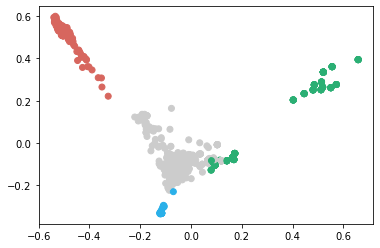

In [134]:
# Kmeans
from sklearn.cluster import KMeans
n_clusters = 4
clf = KMeans(n_clusters=n_clusters, max_iter=300, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

# For larger datasets use mini-batch KMeans, so we dont have to read all data into memory.
# batch_size = 500
# clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
# labels = clf.fit(X)

# Let's plot this with matplotlib to visualize it.
# First we need to make 2D coordinates from the sparse matrix.
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
# Plot clusters
plt.scatter(coords[:, 0], coords[:, 1], c=colors)





In [135]:
# top keywords in the emails

def top_tfidf_feats(row, features, top_n=20000):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

   features     score
0      form  0.337902
1    online  0.272460
2   project  0.262806
3     would  0.259971
4      kang  0.251419
5  learning  0.243807
6      part  0.200409
7  let know  0.190613
8   request  0.188245
9      know  0.174271


In [136]:
# top terms out of all the emails
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=20000):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

print(top_mean_feats(X, features, top_n=10))

          features     score
0          meeting  0.043209
1            event  0.037037
2             join  0.035918
3       join event  0.035257
4        come join  0.035211
5             come  0.035211
6  come join event  0.035211
7          library  0.031531
8             meet  0.027757
9             room  0.023800


In [137]:
# extracts the top terms per cluster
features = vect.get_feature_names()
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    print(y)
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

top_feats_per_cluster(X, labels, features, min_tfidf=0.1, top_n=10)

[3 3 3 2 3 3 3 2 2 3 3 3 3 3 3 3 2 3 3 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 2 3 2
 3 2 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 2 2 0 3 0 0 3 0 0 0 2 3 3 3 0 3 2 0 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 0 0 3 3 0 0 0 0 3 3 0 0 0 3 3 0 0
 3 3 3 3 0 3 2 2 3 2 2 2 2 2 2 2 3 0 3 3 3 3 3 2 3 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 2 3 3 3 3 3 3 0 0 0 3 3 3 3 0 3 3 3 0 0 3 0 3 3 3 3 2 0 0 2 0
 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3
 3 3 3 3 3 3 2 3 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 2 2 2 2 2 

[        features     score
 0  reimbursement  0.249632
 1            art  0.234137
 2            kit  0.233042
 3        housing  0.158979
 4        art kit  0.142999
 5        receipt  0.129772
 6           test  0.128837
 7       resident  0.077988
 8         hostel  0.060306
 9      september  0.057159,
           features     score
 0          meeting  0.160041
 1             come  0.155079
 2        come join  0.155079
 3  come join event  0.155079
 4       join event  0.154600
 5             join  0.127219
 6            event  0.106384
 7          library  0.081404
 8       pm library  0.078334
 9     meeting room  0.076458,
      features     score
 0    intended  0.122253
 1     message  0.068704
 2   quotation  0.067910
 3      devans  0.066125
 4         use  0.063350
 5      sender  0.060925
 6  attachment  0.047341
 7         jos  0.044750
 8  devans jos  0.041484
 9       order  0.040573,
   features     score
 0     meet  0.040856
 1    class  0.023408
 2  session  0.023

[3 3 3 2 3 3 3 2 2 3 3 3 3 3 3 3 2 3 3 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 2 3 2
 3 2 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 2 2 0 3 0 0 3 0 0 0 2 3 3 3 0 3 2 0 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 0 0 3 3 0 0 0 0 3 3 0 0 0 3 3 0 0
 3 3 3 3 0 3 2 2 3 2 2 2 2 2 2 2 3 0 3 3 3 3 3 2 3 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 2 3 3 3 3 3 3 0 0 0 3 3 3 3 0 3 3 3 0 0 3 0 3 3 3 3 2 0 0 2 0
 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3
 3 3 3 3 3 3 2 3 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 2 2 2 2 2 

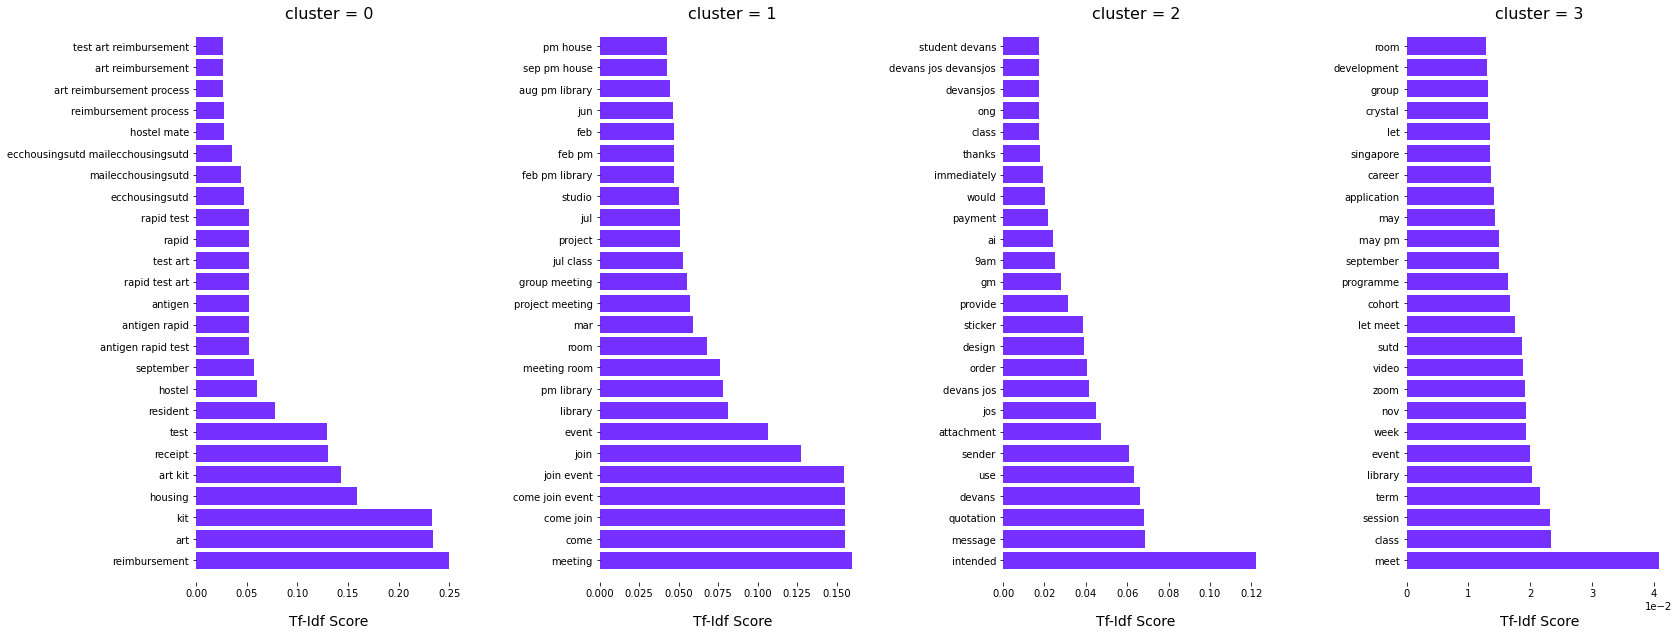

In [138]:
#Use this to print the top terms per cluster with matplotlib.

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(25, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

In [139]:
# km = KMeans(n_clusters=5).fit(df)

# cluster_map = pd.DataFrame()
# cluster_map['data_index'] = df.index.values
# cluster_map['cluster'] = clf.labels_

# cluster_map[cluster_map.cluster == 2]
#df.loc[df.ID == 103, 'FirstName'] = "Matt"
#df.loc[df[clf.labels_==0], 'Meetings'] = df.Categories 
#df.loc = df[clf.labels_==0]['Categories'].fillna('Meeting')
#df['Categories'][mask] = "Meeting"
#df.loc[df[clf.labels_==0], 'Categories'] = 'Meeting'

df['Classifications'] = pd.Series(labels, index=df.index)
# df_new = df[df['Classifications'] != 1]
# df_new

X = df['Body']
y = pd.to_numeric(df['Classifications'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [140]:
# count every word/phrase and put it into a matrix
vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 5,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [141]:
# converting sparse matrices into dense matrices
# replace empty spaces in the matrices with 0 (some sentences might not have a specific word)
X_train_dense = pd.DataFrame(X_train_dtm.toarray(), columns = vect.get_feature_names())
X_test_dense = pd.DataFrame(X_test_dtm.toarray(), columns = vect.get_feature_names())

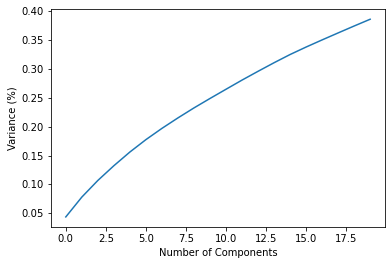

In [148]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

In [142]:
pca = PCA(n_components = 20) # put a reasonable number from graph (70%-90%)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

In [143]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, criterion="entropy", n_jobs=-1, random_state=0)
rfc.fit(X_train_pca, y_train)
predictions = rfc.predict(X_test_pca)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[  9   0   0   0]
 [  0  49   0   0]
 [  0   0  18   1]
 [  0   0   0 130]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        49
           2       1.00      0.95      0.97        19
           3       0.99      1.00      1.00       130

    accuracy                           1.00       207
   macro avg       1.00      0.99      0.99       207
weighted avg       1.00      1.00      1.00       207



In [144]:
cm1 = confusion_matrix(y_test, predictions)
print("Confusion Matrix : \n", cm1)
total1 = sum(sum(cm1))

accuracy1 = (cm1[0,0] + cm1[1,1])/total1
print("Accuracy :", accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print("Sensitivity :", sensitivity1)

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("Specificity :", specificity1)

Confusion Matrix : 
 [[  9   0   0   0]
 [  0  49   0   0]
 [  0   0  18   1]
 [  0   0   0 130]]
Accuracy : 0.28019323671497587
Sensitivity : 1.0
Specificity : 1.0


In [145]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,5),max_iter=500)
mlp.fit(X_train_pca,y_train)
y_pred_class = mlp.predict(X_test_pca)
print(y_pred_class)

[1 1 3 3 3 1 3 3 1 3 1 3 3 3 3 1 3 3 1 2 3 2 1 1 3 1 3 3 3 1 1 1 3 3 1 1 3
 3 2 3 3 1 3 3 3 1 3 1 3 1 3 2 2 3 3 1 2 0 2 1 0 3 1 3 3 2 3 3 3 1 3 3 1 2
 3 3 3 3 0 3 3 3 1 1 3 3 3 3 1 0 2 3 1 1 1 3 3 3 3 3 3 2 3 3 3 1 1 1 3 3 2
 1 3 0 3 2 1 3 0 3 3 3 1 3 1 3 1 3 3 3 3 3 3 3 3 3 2 1 3 3 2 3 3 1 3 3 3 3
 3 3 1 3 3 3 3 0 1 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 1 3 3 3 1 2 3 3 3 1 3 3
 3 2 3 1 3 3 3 2 3 3 0 3 0 3 3 1 3 1 3 3 3 3]


c:\Users\mandi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [146]:
# Saving model to current directory
# Pickle serializes objects so they can be saved to a file, and loaded in a program again later on.
pickle.dump(mlp, open('model.pkl','wb'))
print(X_test_pca)
# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))
print(model.predict(X_test_pca))

[[-1.17159647e-01 -3.44676336e-02 -9.79510122e-02 ... -3.33965824e-01
   2.86320575e-01 -1.82409382e-01]
 [-5.05734273e-01  3.42054327e-01  3.10985848e-01 ...  9.84145034e-02
  -2.42036385e-01  1.62827930e-01]
 [ 4.10058490e-02 -4.31313207e-02 -6.76850663e-02 ...  8.87838829e-03
   4.17545911e-02 -1.04195053e-02]
 ...
 [ 7.46344576e-02 -9.15201544e-02 -6.64276520e-02 ...  7.28056530e-03
  -3.79345435e-02 -6.08577332e-02]
 [ 4.44235260e-02 -6.03222648e-02 -2.77774333e-02 ...  1.32672662e-02
  -2.48047136e-04 -4.28053051e-02]
 [ 7.63290635e-03 -5.67114249e-02 -7.16182226e-02 ... -1.40528222e-02
   5.21927097e-03 -4.03459839e-02]]
[1 1 3 3 3 1 3 3 1 3 1 3 3 3 3 1 3 3 1 2 3 2 1 1 3 1 3 3 3 1 1 1 3 3 1 1 3
 3 2 3 3 1 3 3 3 1 3 1 3 1 3 2 2 3 3 1 2 0 2 1 0 3 1 3 3 2 3 3 3 1 3 3 1 2
 3 3 3 3 0 3 3 3 1 1 3 3 3 3 1 0 2 3 1 1 1 3 3 3 3 3 3 2 3 3 3 1 1 1 3 3 2
 1 3 0 3 2 1 3 0 3 3 3 1 3 1 3 1 3 3 3 3 3 3 3 3 3 2 1 3 3 2 3 3 1 3 3 3 3
 3 3 1 3 3 3 3 0 1 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 1 3 3 3 1 2 3